input_ids torch.Size([64, 32])
attention_mask torch.Size([64, 32])
pixel_values torch.Size([64, 3, 128, 128])
labels torch.Size([64, 32])
Question: [CLS] is there any abnormality? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
Answer: [CLS] yes [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


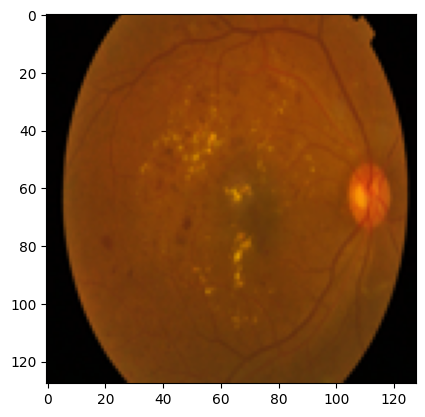

In [1]:
from datasets import load_from_disk
import torch
from torch.utils.data import DataLoader
from transformers import BlipProcessor, BlipForQuestionAnswering, BlipConfig, BlipImageProcessor
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tqdm import tqdm

# Load dataset
dataset = load_from_disk("./RetinaVQA")

# Load config
config = BlipConfig.from_pretrained("Salesforce/blip-vqa-base")

# Select subsets of the dataset
train_data = dataset['train'].select(range(3120))
val_data = dataset['validation'].select(range(890))
test_data = dataset['test'].select(range(450))

# Define VQADataset class
class VQADataset(torch.utils.data.Dataset):
    def __init__(self, data, segment, text_processor, image_processor):
        self.data = data
        self.questions = data['question']
        self.answers = data['answer']
        self.text_processor = text_processor
        self.image_processor = image_processor
        self.max_length = 32
        self.image_height = 128
        self.image_width = 128

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get image + text
        answers = self.answers[idx]
        questions = self.questions[idx]
        image = self.data[idx]['image'].convert('RGB')
        text = self.questions[idx]

        # Process image
        image_encoding = self.image_processor(
            image,
            do_resize=True,
            size=(self.image_height, self.image_width),
            return_tensors="pt"
        )

        # Process text (including attention_mask)
        encoding = self.text_processor(
            None,
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        # Remove batch dimension
        for k, v in encoding.items():
            encoding[k] = v.squeeze()
        encoding["pixel_values"] = image_encoding["pixel_values"][0]

        # Add labels
        labels = self.text_processor.tokenizer.encode(
            answers,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors='pt'
        )[0]
        encoding["labels"] = labels

        return encoding

# Load processor
text_processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
image_processor = BlipImageProcessor.from_pretrained("Salesforce/blip-vqa-base")

# Create datasets
train_vqa_dataset = VQADataset(
    data=train_data,
    segment='train',
    text_processor=text_processor,
    image_processor=image_processor
)

val_vqa_dataset = VQADataset(
    data=val_data,
    segment='validation',
    text_processor=text_processor,
    image_processor=image_processor
)

test_vqa_dataset = VQADataset(
    data=test_data,
    segment='test',
    text_processor=text_processor,
    image_processor=image_processor
)

# Define collate_fn
def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    pixel_values = [item['pixel_values'] for item in batch]
    attention_mask = [item['attention_mask'] for item in batch]
    labels = [item['labels'] for item in batch]

    # Create new batch
    batch = {
        'input_ids': torch.stack(input_ids),
        'attention_mask': torch.stack(attention_mask),
        'pixel_values': torch.stack(pixel_values),
        'labels': torch.stack(labels)
    }

    return batch

# Create dataloaders
train_dataloader = DataLoader(
    train_vqa_dataset,
    collate_fn=collate_fn,
    batch_size=64,
    shuffle=False
)

val_dataloader = DataLoader(
    val_vqa_dataset,
    collate_fn=collate_fn,
    batch_size=64,
    shuffle=False
)

# Inspect a batch
batch = next(iter(train_dataloader))
for k, v in batch.items():
    print(k, v.shape)

# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")
model.to(device)

# Define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

# Inspect an example
image_mean = image_processor.image_mean
image_std = image_processor.image_std

batch_idx = 1
unnormalized_image = (batch["pixel_values"][batch_idx].cpu().numpy() * np.array(image_std)[:, None, None]) + np.array(image_mean)[:, None, None]
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)

print("Question:", text_processor.decode(batch["input_ids"][batch_idx]))
print("Answer:", text_processor.decode(batch["labels"][batch_idx]))
plt.imshow(Image.fromarray(unnormalized_image))



In [2]:
# Training loop
model.train()
for epoch in range(90):
    print(f"Epoch: {epoch}")
    total_loss = []
    for batch in tqdm(train_dataloader):
        # Move batch to device
        batch = {k: v.to(device) for k, v in batch.items()}

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(**batch)
        loss = outputs.loss
        total_loss.append(loss.item())

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    print("Loss:", sum(total_loss))

Epoch: 0


100%|██████████| 49/49 [00:21<00:00,  2.28it/s]


Loss: 245.6921763420105
Epoch: 1


100%|██████████| 49/49 [00:21<00:00,  2.32it/s]


Loss: 49.296433955430984
Epoch: 2


100%|██████████| 49/49 [00:21<00:00,  2.31it/s]


Loss: 6.661315515637398
Epoch: 3


100%|██████████| 49/49 [00:21<00:00,  2.29it/s]


Loss: 3.8815528079867363
Epoch: 4


100%|██████████| 49/49 [00:21<00:00,  2.30it/s]


Loss: 2.673198599368334
Epoch: 5


100%|██████████| 49/49 [00:21<00:00,  2.30it/s]


Loss: 2.2626437172293663
Epoch: 6


100%|██████████| 49/49 [00:21<00:00,  2.30it/s]


Loss: 1.9780853278934956
Epoch: 7


100%|██████████| 49/49 [00:21<00:00,  2.30it/s]


Loss: 1.7656050026416779
Epoch: 8


100%|██████████| 49/49 [00:21<00:00,  2.29it/s]


Loss: 1.6126672197133303
Epoch: 9


100%|██████████| 49/49 [00:21<00:00,  2.30it/s]


Loss: 1.3738239202648401
Epoch: 10


100%|██████████| 49/49 [00:21<00:00,  2.30it/s]


Loss: 1.2370313666760921
Epoch: 11


100%|██████████| 49/49 [00:21<00:00,  2.29it/s]


Loss: 1.2527265511453152
Epoch: 12


100%|██████████| 49/49 [00:21<00:00,  2.30it/s]


Loss: 1.1236399179324508
Epoch: 13


100%|██████████| 49/49 [00:21<00:00,  2.30it/s]


Loss: 1.0314896553754807
Epoch: 14


100%|██████████| 49/49 [00:21<00:00,  2.30it/s]


Loss: 1.0128660760819912
Epoch: 15


100%|██████████| 49/49 [00:21<00:00,  2.31it/s]


Loss: 0.8267523343674839
Epoch: 16


100%|██████████| 49/49 [00:21<00:00,  2.31it/s]


Loss: 0.7913226531818509
Epoch: 17


100%|██████████| 49/49 [00:21<00:00,  2.31it/s]


Loss: 0.6919185942970216
Epoch: 18


100%|██████████| 49/49 [00:21<00:00,  2.31it/s]


Loss: 0.4765942604281008
Epoch: 19


100%|██████████| 49/49 [00:21<00:00,  2.30it/s]


Loss: 0.48642450920306146
Epoch: 20


100%|██████████| 49/49 [00:21<00:00,  2.31it/s]


Loss: 0.6314755971543491
Epoch: 21


100%|██████████| 49/49 [00:21<00:00,  2.31it/s]


Loss: 0.7008099358063191
Epoch: 22


100%|██████████| 49/49 [00:21<00:00,  2.31it/s]


Loss: 0.5098584378138185
Epoch: 23


100%|██████████| 49/49 [00:21<00:00,  2.31it/s]


Loss: 0.427370066056028
Epoch: 24


100%|██████████| 49/49 [00:21<00:00,  2.31it/s]


Loss: 0.3785047382116318
Epoch: 25


100%|██████████| 49/49 [00:21<00:00,  2.31it/s]


Loss: 0.23794471367727965
Epoch: 26


100%|██████████| 49/49 [00:21<00:00,  2.30it/s]


Loss: 0.2706476781750098
Epoch: 27


100%|██████████| 49/49 [00:21<00:00,  2.31it/s]


Loss: 0.23682820005342364
Epoch: 28


100%|██████████| 49/49 [00:21<00:00,  2.31it/s]


Loss: 0.13953605527058244
Epoch: 29


100%|██████████| 49/49 [00:21<00:00,  2.31it/s]


Loss: 0.16512218507705256
Epoch: 30


100%|██████████| 49/49 [00:21<00:00,  2.31it/s]


Loss: 0.2756390501745045
Epoch: 31


100%|██████████| 49/49 [00:21<00:00,  2.31it/s]


Loss: 0.14283085596980527
Epoch: 32


100%|██████████| 49/49 [00:21<00:00,  2.31it/s]


Loss: 0.13834830705309287
Epoch: 33


100%|██████████| 49/49 [00:21<00:00,  2.31it/s]


Loss: 0.0955463292193599
Epoch: 34


100%|██████████| 49/49 [00:21<00:00,  2.31it/s]


Loss: 0.09975588246015832
Epoch: 35


100%|██████████| 49/49 [00:21<00:00,  2.30it/s]


Loss: 0.10835860314546153
Epoch: 36


100%|██████████| 49/49 [00:21<00:00,  2.31it/s]


Loss: 0.11902659863699228
Epoch: 37


100%|██████████| 49/49 [00:21<00:00,  2.31it/s]


Loss: 0.18716418161056936
Epoch: 38


100%|██████████| 49/49 [00:21<00:00,  2.31it/s]


Loss: 0.12765240913722664
Epoch: 39


100%|██████████| 49/49 [00:21<00:00,  2.31it/s]


Loss: 0.2196921391878277
Epoch: 40


100%|██████████| 49/49 [00:21<00:00,  2.31it/s]


Loss: 0.1301794932805933
Epoch: 41


100%|██████████| 49/49 [00:21<00:00,  2.31it/s]


Loss: 0.14769121579593047
Epoch: 42


100%|██████████| 49/49 [00:21<00:00,  2.31it/s]


Loss: 0.09440596657805145
Epoch: 43


100%|██████████| 49/49 [00:21<00:00,  2.30it/s]


Loss: 0.06589059764519334
Epoch: 44


100%|██████████| 49/49 [00:21<00:00,  2.31it/s]


Loss: 0.08406832584296353
Epoch: 45


100%|██████████| 49/49 [00:21<00:00,  2.31it/s]


Loss: 0.11893045797478408
Epoch: 46


100%|██████████| 49/49 [00:21<00:00,  2.31it/s]


Loss: 0.12731048729619943
Epoch: 47


100%|██████████| 49/49 [00:21<00:00,  2.31it/s]


Loss: 0.23941084384568967
Epoch: 48


100%|██████████| 49/49 [00:21<00:00,  2.31it/s]


Loss: 0.21886134427040815
Epoch: 49


100%|██████████| 49/49 [00:21<00:00,  2.31it/s]


Loss: 0.06581072299741209
Epoch: 50


100%|██████████| 49/49 [00:21<00:00,  2.31it/s]


Loss: 0.04785843275021762
Epoch: 51


100%|██████████| 49/49 [00:21<00:00,  2.30it/s]


Loss: 0.04146677631069906
Epoch: 52


100%|██████████| 49/49 [00:21<00:00,  2.31it/s]


Loss: 0.03596497941180132
Epoch: 53


100%|██████████| 49/49 [00:21<00:00,  2.31it/s]


Loss: 0.033506573643535376
Epoch: 54


100%|██████████| 49/49 [00:21<00:00,  2.31it/s]


Loss: 0.03128060736344196
Epoch: 55


100%|██████████| 49/49 [00:21<00:00,  2.31it/s]


Loss: 0.02995353809092194
Epoch: 56


100%|██████████| 49/49 [00:21<00:00,  2.31it/s]


Loss: 0.027273171086562797
Epoch: 57


100%|██████████| 49/49 [00:21<00:00,  2.31it/s]


Loss: 0.025638676073867828
Epoch: 58


100%|██████████| 49/49 [00:21<00:00,  2.30it/s]


Loss: 0.024659419621457346
Epoch: 59


100%|██████████| 49/49 [00:21<00:00,  2.31it/s]


Loss: 0.024092534018564038
Epoch: 60


100%|██████████| 49/49 [00:21<00:00,  2.31it/s]


Loss: 0.02353966172086075
Epoch: 61


100%|██████████| 49/49 [00:21<00:00,  2.31it/s]


Loss: 0.023040566535200924
Epoch: 62


100%|██████████| 49/49 [00:21<00:00,  2.31it/s]


Loss: 0.022567002117284574
Epoch: 63


100%|██████████| 49/49 [00:21<00:00,  2.31it/s]


Loss: 0.022140212618978694
Epoch: 64


100%|██████████| 49/49 [00:21<00:00,  2.31it/s]


Loss: 0.02173272661457304
Epoch: 65


100%|██████████| 49/49 [00:21<00:00,  2.31it/s]


Loss: 0.021358695987146348
Epoch: 66


100%|██████████| 49/49 [00:21<00:00,  2.31it/s]


Loss: 0.021000534339691512
Epoch: 67


100%|██████████| 49/49 [00:21<00:00,  2.30it/s]


Loss: 0.020667677279561758
Epoch: 68


100%|██████████| 49/49 [00:21<00:00,  2.31it/s]


Loss: 0.020351503291749395
Epoch: 69


100%|██████████| 49/49 [00:21<00:00,  2.31it/s]


Loss: 0.020055932109244168
Epoch: 70


100%|██████████| 49/49 [00:21<00:00,  2.31it/s]


Loss: 0.019771828418015502
Epoch: 71


100%|██████████| 49/49 [00:21<00:00,  2.31it/s]


Loss: 0.01950229803333059
Epoch: 72


100%|██████████| 49/49 [00:21<00:00,  2.31it/s]


Loss: 0.019251609584898688
Epoch: 73


100%|██████████| 49/49 [00:21<00:00,  2.31it/s]


Loss: 0.019013368379091844
Epoch: 74


100%|██████████| 49/49 [00:21<00:00,  2.31it/s]


Loss: 0.018786169501254335
Epoch: 75


100%|██████████| 49/49 [00:21<00:00,  2.30it/s]


Loss: 0.018572559201857075
Epoch: 76


100%|██████████| 49/49 [00:21<00:00,  2.31it/s]


Loss: 0.01836623565031914
Epoch: 77


100%|██████████| 49/49 [00:21<00:00,  2.31it/s]


Loss: 0.018168430106015876
Epoch: 78


100%|██████████| 49/49 [00:21<00:00,  2.31it/s]


Loss: 0.017983567937335465
Epoch: 79


100%|██████████| 49/49 [00:21<00:00,  2.31it/s]


Loss: 0.01780743384733796
Epoch: 80


100%|██████████| 49/49 [00:21<00:00,  2.31it/s]


Loss: 0.01763619980920339
Epoch: 81


100%|██████████| 49/49 [00:21<00:00,  2.31it/s]


Loss: 0.01747258445539046
Epoch: 82


100%|██████████| 49/49 [00:21<00:00,  2.31it/s]


Loss: 0.01731700785603607
Epoch: 83


100%|██████████| 49/49 [00:21<00:00,  2.30it/s]


Loss: 0.01716905352077447
Epoch: 84


100%|██████████| 49/49 [00:21<00:00,  2.31it/s]


Loss: 0.017022767446178477
Epoch: 85


100%|██████████| 49/49 [00:21<00:00,  2.31it/s]


Loss: 0.016883360789506696
Epoch: 86


100%|██████████| 49/49 [00:21<00:00,  2.30it/s]


Loss: 0.016751888462749775
Epoch: 87


100%|██████████| 49/49 [00:21<00:00,  2.30it/s]


Loss: 0.016625349016976543
Epoch: 88


100%|██████████| 49/49 [00:21<00:00,  2.30it/s]


Loss: 0.016503051614563446
Epoch: 89


100%|██████████| 49/49 [00:21<00:00,  2.30it/s]

Loss: 0.016382315443479456


Question:  what kind of examination is this image?
Predicted Answer:  this image is from a fundus photography examination which captures a detailed view of the retina.
Actual Answer:  this image is from a fundus photography examination, which captures a detailed view of the retina.


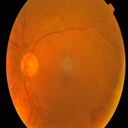

###################################################################
Question:  is there any abnormality?
Predicted Answer:  yes
Actual Answer:  yes


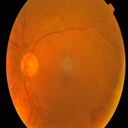

###################################################################
Question:  what is the diagnosis?
Predicted Answer:  yes
Actual Answer:  proliferative dr


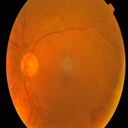

###################################################################
Question:  can this condition cause blindness?
Predicted Answer:  yes if not treated it can lead to blindness
Actual Answer:  yes


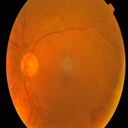

###################################################################
Question:  what might be the cause of this condition?
Predicted Answer:  diabetes complication lead to damage to the blood vessels of the light - sensitive tissue at the retina
Actual Answer:  damaged blood vessels close off, causing the growth of new, abnormal blood vessels in the retina. these new blood vessels are fragile and can leak into


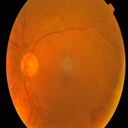

###################################################################
Question:  what kind of examination is this image?
Predicted Answer:  this image is from a fundus photography examination which captures a detailed view of the retina.
Actual Answer:  this image is from a fundus photography examination which captures a detailed view of the retina.


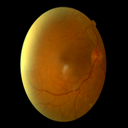

###################################################################
Question:  is there any abnormality?
Predicted Answer:  no
Actual Answer:  no


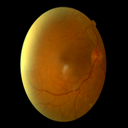

###################################################################
Question:  what is the diagnosis?
Predicted Answer:  the retina image is free from dr
Actual Answer:  healthy retina


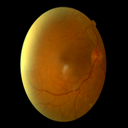

###################################################################
Question:  can this condition cause blindness?
Predicted Answer:  no the retina image is free from dr
Actual Answer:  no the retina image is free from dr


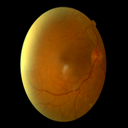

###################################################################
Question:  what might be the cause of this condition?
Predicted Answer:  the retina image is free from dr
Actual Answer:  the retina image is free from dr


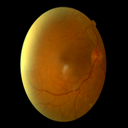

###################################################################
Question:  what kind of examination is this image?
Predicted Answer:  yes
Actual Answer:  this image is from a fundus photography examination, which captures a detailed view of the retina.


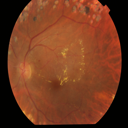

###################################################################
Question:  is there any abnormality?
Predicted Answer:  yes
Actual Answer:  yes


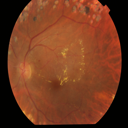

###################################################################
Question:  what is the diagnosis?
Predicted Answer:  yes
Actual Answer:  proliferative dr


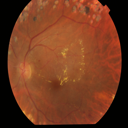

###################################################################
Question:  can this condition cause blindness?
Predicted Answer:  yes
Actual Answer:  yes


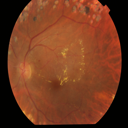

###################################################################
Question:  what might be the cause of this condition?
Predicted Answer:  having diabetes for a long time, poor control of your blood sugar level, high blood pressure and high
Actual Answer:  damaged blood vessels close off, causing the growth of new, abnormal blood vessels in the retina. these new blood vessels are fragile and can leak into


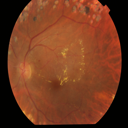

###################################################################
Question:  what kind of examination is this image?
Predicted Answer:  this image is from a fundus photography examination which captures a detailed view of the retina.
Actual Answer:  this image is from a fundus photography examination which captures a detailed view of the retina.


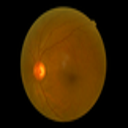

###################################################################
Question:  is there any abnormality?
Predicted Answer:  no
Actual Answer:  no


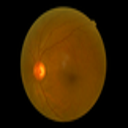

###################################################################
Question:  what is the diagnosis?
Predicted Answer:  the retina image is free from dr
Actual Answer:  healthy retina


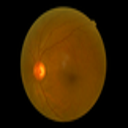

###################################################################
Question:  can this condition cause blindness?
Predicted Answer:  no the retina image is free from dr
Actual Answer:  no the retina image is free from dr


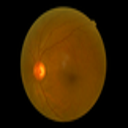

###################################################################
Question:  what might be the cause of this condition?
Predicted Answer:  the retina image is free from dr
Actual Answer:  the retina image is free from dr


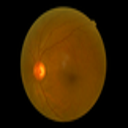

###################################################################
Question:  what kind of examination is this image?
Predicted Answer:  yes
Actual Answer:  this image is from a fundus photography examination, which captures a detailed view of the retina.


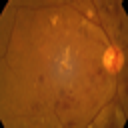

###################################################################
Question:  is there any abnormality?
Predicted Answer:  yes
Actual Answer:  yes


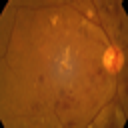

###################################################################
Question:  what is the diagnosis?
Predicted Answer:  yes
Actual Answer:  severe dr


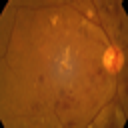

###################################################################
Question:  can this condition cause blindness?
Predicted Answer:  yes
Actual Answer:  yes


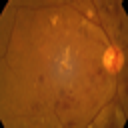

###################################################################
Question:  what might be the cause of this condition?
Predicted Answer:  having diabetes for a long time, poor control of your blood sugar level, high blood pressure and high
Actual Answer:  having diabetes for a long time, poor control of your blood sugar level, high blood pressure and high cholesterol


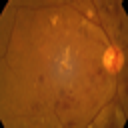

###################################################################


: 

In [3]:
# add batch dimension + move to GPU|
for x in range(25):
    sample = val_vqa_dataset[x]
    print("Question: ",text_processor.decode(sample['input_ids'], skip_special_tokens=True))
    sample = {k: v.unsqueeze(0).to(device) for k,v in sample.items()}

    # forward pass
    outputs = model.generate(pixel_values=sample['pixel_values'],
                            input_ids=sample['input_ids'])
    print("Predicted Answer: ",text_processor.decode(outputs[0],skip_special_tokens=True))
    print("Actual Answer: ",text_processor.decode(sample['labels'][0], skip_special_tokens=True))
    #########################################################################
    unnormalized_image = (sample["pixel_values"][0].cpu().numpy() * np.array(image_std)[:, None, None]) + np.array(image_mean)[:, None, None]
    unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
    unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
    display(Image.fromarray(unnormalized_image))
    #########################################################################
    print("###################################################################")